# The Heuristic Threat Detector Layer


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tensorflow as tf
from aegomoku.utils import analyse_board
from aegomoku.policies.heuristic_policy import HeuristicPolicy
from aegomoku.gomoku_board import GomokuBoard

In [5]:
BOARD_SIZE = 15

In [6]:
stones = "C11F9E9G8F7G7G9H8I8H7I6I9F6H6H9I5F10"

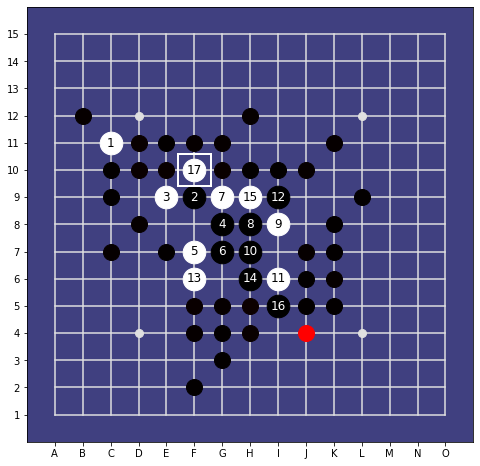

In [7]:
heuristics = HeuristicPolicy(BOARD_SIZE)
analyse_board(BOARD_SIZE, stones, heuristics, disp_width=8)

In [8]:
board = GomokuBoard(BOARD_SIZE, stones=stones)
Move = board.Stone

In [9]:
from aegomoku.utils import expand
heuristics.call(expand(board.math_rep))[0].shape

(15, 15)

In [10]:
from aegomoku.policies.threat_detector import ThreatDetector

In [11]:
from aegomoku.utils import expand

In [12]:
combine = tf.keras.layers.Conv2D(
    name='heuristic_priority',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    activation='relu',
    kernel_initializer=tf.constant_initializer([1., 1.]))

In [13]:
project = tf.keras.layers.Conv2D(
    name='project',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([1., 2., 3., 4., 5., 6., 7, 8]))

In [14]:
peel = tf.keras.layers.Conv2D(
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([
        [[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]
    ]),
    bias_initializer=tf.constant_initializer(0.),
    trainable=False)

In [15]:
flatten = tf.keras.layers.Flatten()

In [16]:
def print_channel(data, channel=None):
    """
    :param data: policy output, either one or six channels
    :param channel: if data is 6-channel, number of channel from 1: strongest offensive opportunity to 6 weakest defensive
    :return:
    """
    if np.shape(data)[-1] == 8:
        if channel is not None:
            channel -= 1
            data = np.expand_dims(data[:,:,:,channel], -1)
        else:
            data = project(data)
    data = peel(data)
    print((data.numpy().reshape([15, 15]) ).astype(np.uint))

In [17]:
criticality = tf.keras.layers.Conv2D(
    name='weights',
    filters=1, kernel_size=(1, 1),
    trainable=False,
    kernel_initializer=tf.constant_initializer([999, 333, 4, 4, 2, 2, 1, 1]))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [6 0 6 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 6 6 6 0 0 0 0 0 0 0 0 0 0 0]
 [6 6 0 6 6 0 0 0 0 0 0 0 0 0 0]
 [0 6 6 6 0 0 0 0 0 0 0 0 0 0 0]
 [6 0 6 0 6 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
16.0


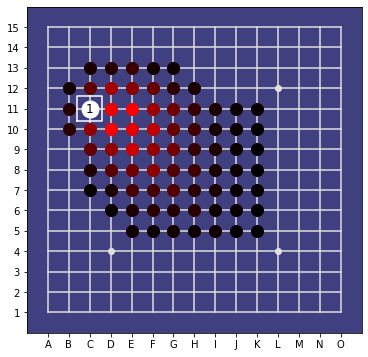

In [18]:
stones = "C11"  #F9E9G8F7G7G9H8H7F6I9J8" #
board = GomokuBoard(BOARD_SIZE, stones=stones)
analyse_board(15, stones, heuristics, disp_width=6)

detector = ThreatDetector(BOARD_SIZE)
output = detector(expand(board.math_rep))

crit0 = criticality(tf.sign(output))
crit = tf.squeeze(flatten(crit0))

threshold = 0.004
softmax = tf.keras.layers.Softmax()(crit)
softmax = tf.keras.activations.relu(softmax - threshold)

softmax = tf.reshape(softmax, [1, 17, 17, 1])
sup = np.max(softmax, axis=None)
threshold = sup * .01
softmax = tf.nn.relu(softmax - threshold)
softmax = softmax / np.sum(softmax)

print_channel(softmax*100)
print(np.sum(tf.sign(softmax)))

In [19]:
print_channel(crit0)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [21]:
from aegomoku.policies.heuristic_advice import HeuristicAdviserParams, HeuristicAdviser
adviser = HeuristicAdviser(HeuristicAdviserParams(board_size=BOARD_SIZE))
p, v = adviser.call(expand(board.math_rep))
print((p.numpy().reshape([BOARD_SIZE, BOARD_SIZE])*100).astype(np.uint))
v

In [44]:
advisable = adviser.get_advisable_actions(board.math_rep)
print([board.Stone(i) for i in advisable])

[B12, D11, D10, E10, F10, G10, H10, J10, D9, H9, I9, E8, F8, I8, J8, D7, E7, H7, I7, E6, F6, I6, E5]


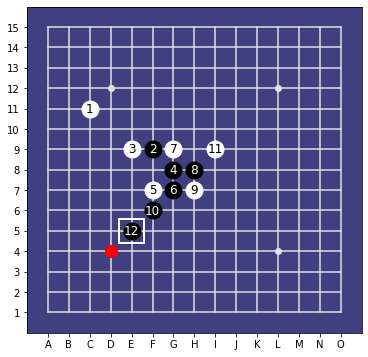

In [48]:
stones = "C11F9E9G8F7G7G9H8H7F6I9E5" #J8" #
board = GomokuBoard(BOARD_SIZE, stones=stones)
analyse_board(BOARD_SIZE, stones, adviser, disp_width=6)

In [49]:
advisable = adviser.get_advisable_actions(board.math_rep, cut_off=.1)
advisable

[168]

- I need a primary detector to identify open fours (and maybe open threes as intermediate threats)
- That primary detector output will be added to the topological-value policy, the sum being fed into a softmax. Hence prioretized moves effectively override the soft topoligical policy.
- The topological value makes sense. However, the policy might better equally consider any adjacent and selective next-to-adjacent positions. That's to avoid early bias
- The adviser should be able to further reduce the number of options by providing only options with higher severity than that of the current threat level
- It might suffice to distinguish immediate (open 4) and intermediate (will-be open 4)

## Forward-Looking Layers
Forward-looking layers treat threat positions as potential stones

In [15]:
from aegomoku.policies.forward_looking import ForwardLookingLayer

fwll = ForwardLookingLayer(BOARD_SIZE)

In [16]:
output = detector(board.math_rep)
fwd = np.squeeze(fwll(fwll(output)))

In [17]:
print((fwd[:, :, 3]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 206   0   0   0   0   0   0 206   0   0   0   0   0]
 [  0   0   0   0   0 206   0   0  92   0 206   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  92   0  92   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  92   0 288   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 288   0  92   0   0   0   0]
 [  0   0   0   0   0   0 288 288 488   0 288 288  92   0   0   0   0]
 [  0   0   0   0   0   0  92   0 488   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  92   0 288   0   0   0   0   0   0   0   0   0]
 [  0 

In [16]:
print((fwd[:, :, 4]*100.).astype(int))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 292   0   0  91   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  91   0 284 284 384   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 292  91   0 292   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 284   0   0   0   0]
 [  0   0   0   0   0  91   0   0   0   0   0 284   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 384   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  91   0   0 284 292   0   0   0   0   0]
 [  0   0   0   0   0   0 292   0 284   0 284   0   0   0   0   0   0]
 [  0   0   0   0   0   0 292 284  91  91   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  91   0   0   0  91   0   0   0   0   0   0]
 [  0 

---

# The combined heuristic policy-value function

### TODO: Take this policy into the Arena.ipynb to continue MCTS research!

In [17]:
from aegomoku.policies.heuristic_policy import HeuristicPolicy

# cut_off is used to restrict advice to those positions close enough to the maximum
policy = HeuristicPolicy(BOARD_SIZE, cut_off=.1)

In [18]:
pi = lambda s: policy(s)[0]
v =  lambda s: policy(s)[1]
board.print_pi(pi)
print()
print(v(board.math_rep))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   3   4   3   1   0   0   0   0   0   0   0   0]
 [  0 494   4  10  11   8   6   2   0   2   1   2   0   0   0]
 [  0   4   0 771 256 508   9   5   1   3 527   2   1   0   0]
 [  0   7  13 513 537  16 504   5   1 529   5   5   0   0   0]
 [  0   5  15  19   0   0   0   0   0   3   8 239   1   0   0]
 [  0   5  12  20  18  11   0   0   0   8 240   3   0   0   0]
 [  0   3  10  17  21   0   0   0   7 501 251   1   0   0   0]
 [  0   2   6  15  18   0   3   0   0 484 499   0   1   0   0]
 [  0   0   4   8  10 745 251 999   0 488 250   5   0   0   0]
 [  0   0   1   2   5 493 237 760   2   0   6   1   1   0   0]
 [  0   0   0   0   0   0 246   0   0   4   1   1   0   0   0]
 [  0   0   0   0   0 246   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

tf.Tensor(-0.00461175033262567, shape=(), dtype=float

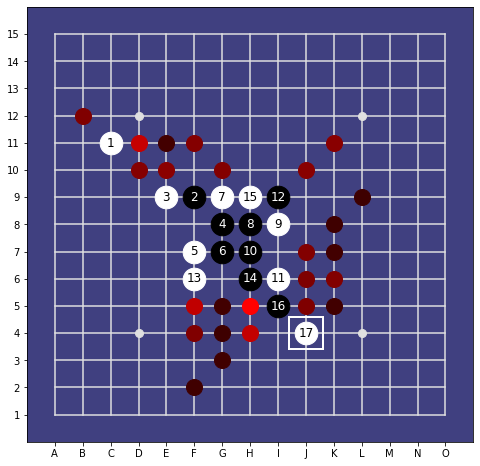

In [19]:
analyse_board(15, stones, policy)

Observe that all critical positions are also *advisable*.

In [20]:
print([Move(a) for a in policy.get_advisable_actions(board.math_rep)])

[B12, D11, E11, F11, K11, D10, E10, G10, J10, L9, K8, J7, K7, J6, K6, F5, G5, H5, J5, K5, F4, G4, H4, G3, F2]


## Super-critical positions

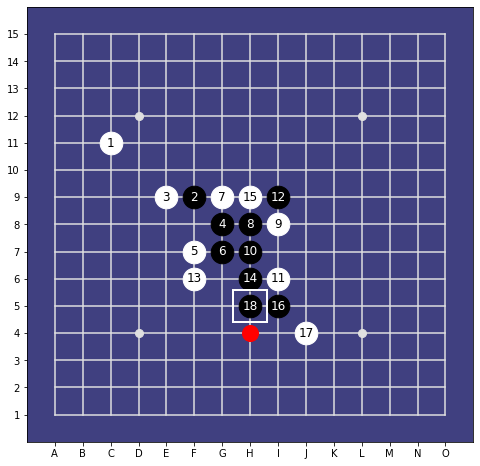

In [21]:
analyse_board(15, stones+"H5", policy)